#**FAKE NEWS PREDICTION**

#Importing Libraries

In [1]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.sparse import hstack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

# Data Cleaning (Training data)

In [2]:
#Loading tab seperated data
train = pd.read_csv('/content/train.tsv', delimiter='\t')

In [3]:
train.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


In [4]:
train.shape

(30000, 6)

In [5]:
train.sample(1)

,Unnamed: 0,title,text,subject,date,label
27055,13345,"Fearing for post-Brexit prosperity and peace, ...",Northern Irish sheep farmers like John Sherida...,worldnews,"December 1, 2017",1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   title       30000 non-null  object
 2   text        30000 non-null  object
 3   subject     30000 non-null  object
 4   date        30000 non-null  object
 5   label       30000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


In [7]:
train.drop(columns = ['Unnamed: 0'], inplace = True)

In [8]:
train

,title,text,subject,date,label
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0
...,...,...,...,...,...
29995,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politicsNews,"December 6, 2016",1
29996,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,"October 11, 2017",1
29997,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,"June 28, 2016",0
29998,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,"November 2, 2017",1


In [9]:

# politics and politicsNews are same thing
train['subject'] = train['subject'].replace('politicsNews', 'politics')
train['subject'] = train['subject'].replace('left-news', 'left news')
train['subject'] = train['subject'].replace('Middle-east', 'Middle east')
train['subject'] = train['subject'].replace('US_News', 'US news')

In [10]:
train

,title,text,subject,date,label
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politics,"July 22, 2017",1
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politics,"November 2, 2017",1
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left news,"Sep 17, 2016",0
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0
...,...,...,...,...,...
29995,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politics,"December 6, 2016",1
29996,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,"October 11, 2017",1
29997,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,"June 28, 2016",0
29998,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,"November 2, 2017",1


In [11]:
# Function to handle multiple date formats and invalid entries
def convert_date(date_str):
    date_str = str(date_str).strip()
    for fmt in ("%B %d, %Y", "%b %d, %Y"):  # this is the format for date with full/abbreviated month name
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT

train['date'] = train['date'].apply(convert_date)

In [12]:
train.head()

,title,text,subject,date,label
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politics,2017-07-22,1
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,2017-06-19,0
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politics,2017-11-02,1
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left news,2016-09-17,0
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,2017-05-26,0


In [13]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

In [14]:
train

,title,text,subject,date,label,day,month,year
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politics,2017-07-22,1,22.0,7.0,2017.0
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,2017-06-19,0,19.0,6.0,2017.0
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politics,2017-11-02,1,2.0,11.0,2017.0
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left news,2016-09-17,0,17.0,9.0,2016.0
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,2017-05-26,0,26.0,5.0,2017.0
...,...,...,...,...,...,...,...,...
29995,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politics,2016-12-06,1,6.0,12.0,2016.0
29996,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,2017-10-11,1,11.0,10.0,2017.0
29997,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,2016-06-28,0,28.0,6.0,2016.0
29998,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,2017-11-02,1,2.0,11.0,2017.0


In [15]:
train['day'] = train['day'].apply(lambda x: int(x) if pd.notna(x) else 0)
train['month'] = train['month'].apply(lambda x: int(x) if pd.notna(x) else 0)
train['year'] = train['year'].apply(lambda x: int(x) if pd.notna(x) else 0)

In [16]:
train

,title,text,subject,date,label,day,month,year
0,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politics,2017-07-22,1,22,7,2017
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,2017-06-19,0,19,6,2017
2,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politics,2017-11-02,1,2,11,2017
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left news,2016-09-17,0,17,9,2016
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,2017-05-26,0,26,5,2017
...,...,...,...,...,...,...,...,...
29995,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politics,2016-12-06,1,6,12,2016
29996,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,2017-10-11,1,11,10,2017
29997,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,2016-06-28,0,28,6,2016
29998,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,2017-11-02,1,2,11,2017


In [17]:
train.drop(columns = ['date'], inplace = True)

# Data Cleaning (Test data)


In [18]:
test = pd.read_csv('/content/test.tsv', delimiter='\t')

In [19]:
test

,Unnamed: 0,title,text,subject,date,label
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,"November 9, 2016",1
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,"December 7, 2017",1
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,"Jan 21, 2017",0
...,...,...,...,...,...,...
8262,5469,Russian MP says Flynn was forced to resign to ...,A senior Russian lawmaker said on Tuesday it w...,politicsNews,"February 14, 2017",1
8263,5079,Highlights: The Trump presidency on March 7 at...,Highlights of the day for U.S. President Donal...,politicsNews,"March 7, 2017",1
8264,20425,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left-news,"Jun 13, 2016",0
8265,22063,John McCain and The Cancer of Conflict,Patrick Henningsen 21st Century WireThis week ...,US_News,"July 21, 2017",0


In [20]:
test.drop(columns = ['Unnamed: 0'], inplace = True)

In [21]:
# politics and politicsNews are same thing
test['subject'] = test['subject'].replace('politicsNews', 'politics')
test['subject'] = test['subject'].replace('left-news', 'left news')
test['subject'] = test['subject'].replace('Middle-east', 'Middle east')
test['subject'] = test['subject'].replace('US_News', 'US news')

In [22]:
test

,title,text,subject,date,label
0,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0
1,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politics,"November 9, 2016",1
2,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0
3,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politics,"December 7, 2017",1
4,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left news,"Jan 21, 2017",0
...,...,...,...,...,...
8262,Russian MP says Flynn was forced to resign to ...,A senior Russian lawmaker said on Tuesday it w...,politics,"February 14, 2017",1
8263,Highlights: The Trump presidency on March 7 at...,Highlights of the day for U.S. President Donal...,politics,"March 7, 2017",1
8264,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left news,"Jun 13, 2016",0
8265,John McCain and The Cancer of Conflict,Patrick Henningsen 21st Century WireThis week ...,US news,"July 21, 2017",0


In [23]:
test['subject'].value_counts()

,count
subject,
politics,3309
worldnews,1906
News,1713
left news,750
Government News,292
US news,149
Middle east,148


In [24]:
# Function to handle multiple date formats and invalid entries
def convert_date(date_str):
    date_str = str(date_str).strip()
    for fmt in ("%B %d, %Y", "%b %d, %Y"):  # this is the format for date with full/abbreviated month name
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT

test['date'] = test['date'].apply(convert_date)

In [25]:
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

In [26]:
test['day'] = test['day'].apply(lambda x: int(x) if pd.notna(x) else 0)
test['month'] = test['month'].apply(lambda x: int(x) if pd.notna(x) else 0)
test['year'] = test['year'].apply(lambda x: int(x) if pd.notna(x) else 0)

In [27]:
test

,title,text,subject,date,label,day,month,year
0,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,2016-02-14,0,14,2,2016
1,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politics,2016-11-09,1,9,11,2016
2,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,2017-11-09,0,9,11,2017
3,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politics,2017-12-07,1,7,12,2017
4,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left news,2017-01-21,0,21,1,2017
...,...,...,...,...,...,...,...,...
8262,Russian MP says Flynn was forced to resign to ...,A senior Russian lawmaker said on Tuesday it w...,politics,2017-02-14,1,14,2,2017
8263,Highlights: The Trump presidency on March 7 at...,Highlights of the day for U.S. President Donal...,politics,2017-03-07,1,7,3,2017
8264,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left news,2016-06-13,0,13,6,2016
8265,John McCain and The Cancer of Conflict,Patrick Henningsen 21st Century WireThis week ...,US news,2017-07-21,0,21,7,2017


In [28]:
test.drop(columns = ['date'], inplace = True)

In [29]:
test

,title,text,subject,label,day,month,year
0,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,0,14,2,2016
1,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politics,1,9,11,2016
2,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,0,9,11,2017
3,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politics,1,7,12,2017
4,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left news,0,21,1,2017
...,...,...,...,...,...,...,...
8262,Russian MP says Flynn was forced to resign to ...,A senior Russian lawmaker said on Tuesday it w...,politics,1,14,2,2017
8263,Highlights: The Trump presidency on March 7 at...,Highlights of the day for U.S. President Donal...,politics,1,7,3,2017
8264,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left news,0,13,6,2016
8265,John McCain and The Cancer of Conflict,Patrick Henningsen 21st Century WireThis week ...,US news,0,21,7,2017


#EDA

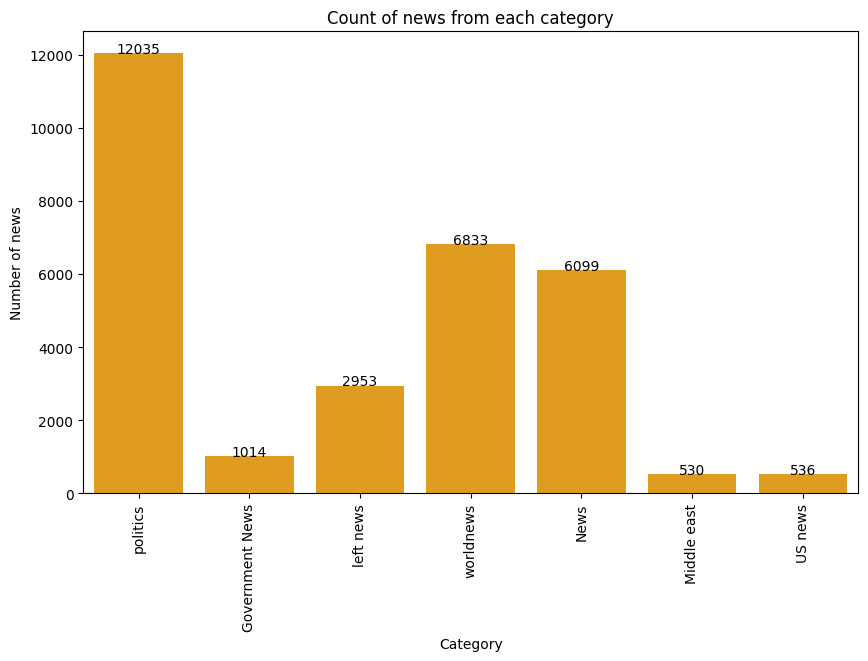

In [30]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = train['subject'], color = 'orange')
plt.ylabel('Number of news')
plt.xlabel('Category')
plt.xticks(rotation = 90)
plt.title('Count of news from each category')

for data in ax.patches:
    bar_height = data.get_height()
    bar_x = data.get_x() + data.get_width() / 2
    ax.text(bar_x, bar_height + 0.1, f'{int(bar_height)}', ha='center', fontsize=10)
plt.show()

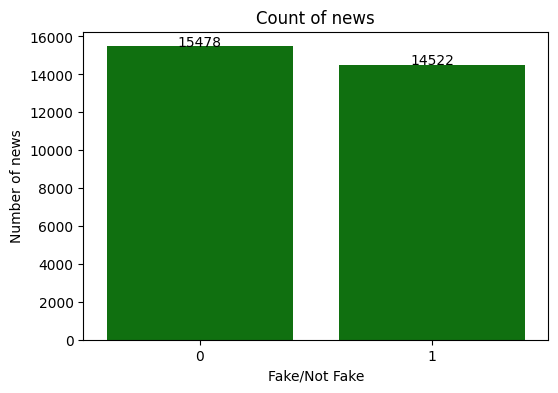

In [31]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x = train['label'], color = 'green')
plt.ylabel('Number of news')
plt.xlabel('Fake/Not Fake')
plt.title('Count of news')

for data in ax.patches:
    bar_height = data.get_height()
    bar_x = data.get_x() + data.get_width() / 2
    ax.text(bar_x, bar_height + 1, f'{int(bar_height)}', ha='center', fontsize=10)
plt.show()

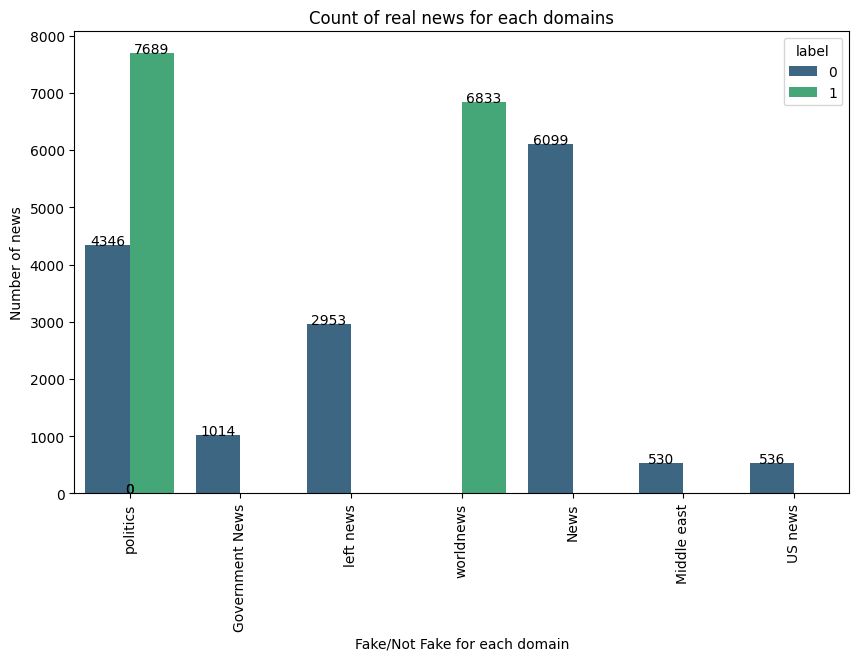

In [32]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = train['subject'], hue = train['label'], palette = 'viridis')
plt.ylabel('Number of news')
plt.xlabel('Fake/Not Fake for each domain')
plt.xticks(rotation = 90)
plt.title('Count of real news for each domains')

for data in ax.patches:
    bar_height = data.get_height()
    bar_x = data.get_x() + data.get_width() / 2
    ax.text(bar_x, bar_height + 1, f'{int(bar_height)}', ha='center', fontsize=10)
plt.show()

# Data Preprocessing (Training data)

##Encoding Subject Column

In [33]:
le = LabelEncoder()
train['subject'] = le.fit_transform(train['subject'])

##Converting to Lower case

In [34]:
def to_lower(text):
    return text.lower()

train['title'] = train['title'].apply(to_lower)
train['text'] = train['text'].apply(to_lower)

##Removing HTML tags if present

In [35]:
def remove_html(text):
     cleaned_text = re.sub(r'<.*?>', '', text)
     return cleaned_text

train['title'] = train['title'].apply(remove_html)
train['text'] = train['text'].apply(remove_html)

##Expanding common contractions

In [36]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.7 MB/s eta 0:00:00


In [37]:
from contractions import fix

def expand_contractions(text):
    expanded_text = fix(text)
    return expanded_text

train['title'] = train['title'].apply(expand_contractions)
train['text'] = train['text'].apply(expand_contractions)

## Removing punctuation

In [38]:
nltk.download('punkt_tab')
nltk.download('stopwords')

def remove_punctuation_with_tokenization(text):
    tokens = word_tokenize(text)
    return ' '.join(word for word in tokens if word.isalnum())

train['title'] = train['title'].apply(remove_punctuation_with_tokenization)
train['text'] = train['text'].apply(remove_punctuation_with_tokenization)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Removing Stopwords

In [39]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

train['title'] = train['title'].apply(remove_stopwords)
train['text'] = train['text'].apply(remove_stopwords)

##Lemmatization

In [40]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
  words = word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  lemmatized_text = ' '.join(lemmatized_words)
  return lemmatized_text

train['title'] = train['title'].apply(lemmatize_words)
train['text'] = train['text'].apply(lemmatize_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [41]:
train

,title,text,subject,label,day,month,year
0,head say trump remark russia interference,former cia director john brennan friday critic...,5,1,22,7,2017
1,believe punishment hispanic store owner swindl...,man come store information much fraudster exce...,0,0,19,6,2017
2,federal reserve governor powell policy view word,president donald trump thursday tapped federal...,5,1,2,11,2017
3,scoundrel hillary supporter start trumpleaks move,hillary clinton ally david brock offering pay ...,4,0,17,9,2016
4,nancy pelosi arrogantly dismisses question cro...,pleading ignorance perfect ploy nancy pelosi b...,5,0,26,5,2017
...,...,...,...,...,...,...,...
29995,aerospace industry urge trump help bank resume...,chief executive aerospace industry association...,5,1,6,12,2016
29996,highlight hong kong leader carrie lam delivers...,following highlight maiden policy address hong...,6,1,11,10,2017
29997,obama literally laugh claim brexit mean trump ...,one thing president barack obama threatened do...,2,0,28,6,2016
29998,syrian army take full control deir islamic sta...,syrian army ally taken full control deir city ...,6,1,2,11,2017


#Data Preprocessing (Test data)

##Encoding Subject Column

In [42]:
le = LabelEncoder()
test['subject'] = le.fit_transform(test['subject'])

## Converting to Lower Case

In [43]:
test['title'] = test['title'].apply(to_lower)
test['text'] = test['text'].apply(to_lower)

## Removing HTML tags if present

In [44]:
test['title'] = test['title'].apply(remove_html)
test['text'] = test['text'].apply(remove_html)

##Expanding common contractions

In [45]:
test['title'] = test['title'].apply(expand_contractions)
test['text'] = test['text'].apply(expand_contractions)

## Removing punctuation

In [46]:
test['title'] = test['title'].apply(remove_punctuation_with_tokenization)
test['text'] = test['text'].apply(remove_punctuation_with_tokenization)

## Removing stopwords

In [47]:
test['title'] = test['title'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

## Lemmatization

In [48]:
test['title'] = test['title'].apply(lemmatize_words)
test['text'] = test['text'].apply(lemmatize_words)

In [49]:
test

,title,text,subject,label,day,month,year
0,conservative hate donald trump said planned pa...,donald trump exactly stranger making large gro...,2,0,14,2,2016
1,trump victory may create new tension islam ind...,donald trump election victory may create fresh...,5,1,9,11,2016
2,watch hundred illegal alien storm senate build...,couple quick question come mind american see i...,5,0,9,11,2017
3,democratic senator franken resign cnn citing s...,democratic senator al franken announce resigna...,5,1,7,12,2017
4,gang domestic terrorist violently attack lone ...,warning violence graphic trump supporter used ...,4,0,21,1,2017
...,...,...,...,...,...,...,...
8262,russian mp say flynn forced resign damage tie,senior russian lawmaker said tuesday clear pre...,5,1,14,2,2017
8263,highlight trump presidency march 7 est,highlight day president donald trump administr...,5,1,7,3,2017
8264,shocker muslim terrorist gay used gay dating f...,course mateen muslim father vehemently denies ...,4,0,13,6,2016
8265,john mccain cancer conflict,patrick henningsen 21st century wirethis week ...,3,0,21,7,2017


# Applying Machine Learning Model

In [50]:
test

,title,text,subject,label,day,month,year
0,conservative hate donald trump said planned pa...,donald trump exactly stranger making large gro...,2,0,14,2,2016
1,trump victory may create new tension islam ind...,donald trump election victory may create fresh...,5,1,9,11,2016
2,watch hundred illegal alien storm senate build...,couple quick question come mind american see i...,5,0,9,11,2017
3,democratic senator franken resign cnn citing s...,democratic senator al franken announce resigna...,5,1,7,12,2017
4,gang domestic terrorist violently attack lone ...,warning violence graphic trump supporter used ...,4,0,21,1,2017
...,...,...,...,...,...,...,...
8262,russian mp say flynn forced resign damage tie,senior russian lawmaker said tuesday clear pre...,5,1,14,2,2017
8263,highlight trump presidency march 7 est,highlight day president donald trump administr...,5,1,7,3,2017
8264,shocker muslim terrorist gay used gay dating f...,course mateen muslim father vehemently denies ...,4,0,13,6,2016
8265,john mccain cancer conflict,patrick henningsen 21st century wirethis week ...,3,0,21,7,2017


In [51]:
train

,title,text,subject,label,day,month,year
0,head say trump remark russia interference,former cia director john brennan friday critic...,5,1,22,7,2017
1,believe punishment hispanic store owner swindl...,man come store information much fraudster exce...,0,0,19,6,2017
2,federal reserve governor powell policy view word,president donald trump thursday tapped federal...,5,1,2,11,2017
3,scoundrel hillary supporter start trumpleaks move,hillary clinton ally david brock offering pay ...,4,0,17,9,2016
4,nancy pelosi arrogantly dismisses question cro...,pleading ignorance perfect ploy nancy pelosi b...,5,0,26,5,2017
...,...,...,...,...,...,...,...
29995,aerospace industry urge trump help bank resume...,chief executive aerospace industry association...,5,1,6,12,2016
29996,highlight hong kong leader carrie lam delivers...,following highlight maiden policy address hong...,6,1,11,10,2017
29997,obama literally laugh claim brexit mean trump ...,one thing president barack obama threatened do...,2,0,28,6,2016
29998,syrian army take full control deir islamic sta...,syrian army ally taken full control deir city ...,6,1,2,11,2017


In [52]:
tfidf = TfidfVectorizer(max_features = 2000, ngram_range = (1,2))

train_title = tfidf.fit_transform(train['title'])
test_title = tfidf.transform(test['title'])

tfidf_text = TfidfVectorizer(max_features = 5000, ngram_range = (1,2))
train_text = tfidf_text.fit_transform(train['text'])
test_text = tfidf_text.transform(test['text'])

train_combined = hstack([train_title, train_text])
test_combined = hstack([test_title, test_text])

In [53]:
train_final = hstack([train_combined, train['subject'].values.reshape(-1, 1)])
test_final = hstack([test_combined, test['subject'].values.reshape(-1, 1)])

In [54]:
train_final = hstack([train_final,train[['day','month','year']].values.astype(int)])
test_final = hstack([test_final,test[['day','month','year']].values.astype(int)])

In [55]:
train_final

<30000x7004 sparse matrix of type '<class 'numpy.float64'>'
	with 4447909 stored elements in COOrdinate format>

In [56]:
test_final

<8267x7004 sparse matrix of type '<class 'numpy.float64'>'
	with 1240382 stored elements in COOrdinate format>

In [57]:
lr = LogisticRegression(max_iter = 2000)
lr.fit(train_final, train['label'])
y_pred_lr = lr.predict(test_final)
print(classification_report(test['label'], y_pred_lr))
print(confusion_matrix(test['label'], y_pred_lr))
print("Accuracy: ", accuracy_score(test['label'], y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4284
           1       0.98      1.00      0.99      3983

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267

[[4221   63]
 [  16 3967]]
Accuracy:  0.9904439337123503


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_final, train['label'])
y_pred_rfc = rfc.predict(test_final)
print(classification_report(test['label'], y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      3983

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267

[[4251   33]
 [  24 3959]]


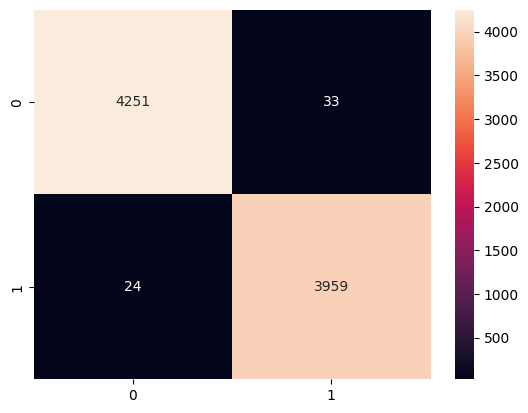

In [83]:
sns.heatmap(confusion_matrix(test['label'], y_pred_rfc), annot=True, fmt='d')
plt.show()

In [59]:
auc_score = roc_auc_score(test['label'], y_pred_rfc)
print('ROC-AUC Score: ', auc_score)

ROC-AUC Score:  0.9931356549649737


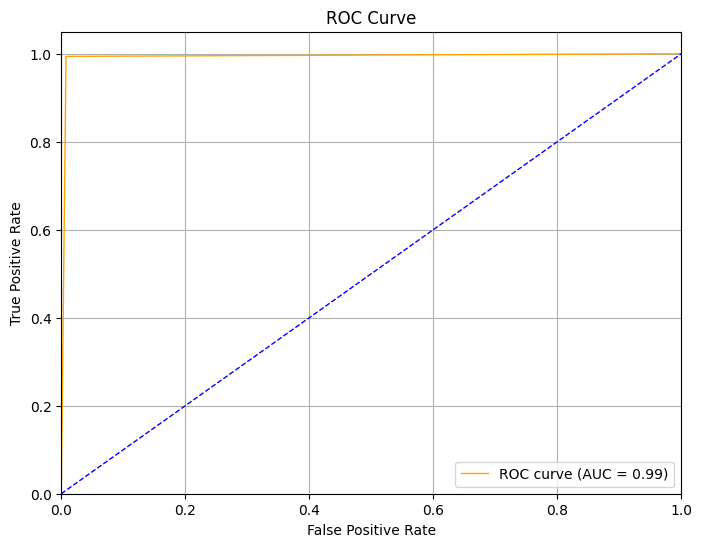

In [60]:
fpr, tpr, _ = roc_curve(test['label'], y_pred_rfc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=1, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [61]:
print("Accuracy: ", accuracy_score(test['label'], y_pred_rfc))
print("Precision: ", precision_score(test['label'], y_pred_rfc))
print("Recall: ", recall_score(test['label'], y_pred_rfc))
print("F1 Score: ", f1_score(test['label'], y_pred_rfc))
print("ROC AUC: ", roc_auc_score(test['label'], y_pred_rfc))

Accuracy:  0.9931051167291641
Precision:  0.9917334669338678
Recall:  0.9939743911624404
F1 Score:  0.9928526645768025
ROC AUC:  0.9931356549649737


#Applying Deep Learning Model

In [62]:
train_texts = train['text']
# Tokenization and Padding of text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
word_index = tokenizer.word_index

max_sequence_length = 200
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)


test_text = test['text']
test_sequences = tokenizer.texts_to_sequences(test_text)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)


model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=max_sequence_length),  # Applying Embedding Layer
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    LSTM(16, return_sequences=False),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
callbacks = callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=0.00001)
]

model.fit(train_data, train['label'], validation_data=(test_data, test['label']), epochs=20, batch_size=32, callbacks = callbacks)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.8910 - loss: 0.2508 - precision: 0.8795 - recall: 0.9018 - val_accuracy: 0.9588 - val_loss: 0.1213 - val_precision: 0.9874 - val_recall: 0.9262 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.9813 - loss: 0.0633 - precision: 0.9776 - recall: 0.9839 - val_accuracy: 0.9717 - val_loss: 0.0750 - val_precision: 0.9578 - val_recall: 0.9847 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9887 - loss: 0.0348 - precision: 0.9870 - recall: 0.9897 - val_accuracy: 0.9803 - val_loss: 0.0621 - val_precision: 0.9714 - val_recall: 0.9882 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9915 - loss: 0.0286 - precision: 0.9905 - recall: 0.9917 - val_accuracy: 0.9829 - val_loss: 0.0633 - val_precision: 0.9767 - val_recall: 0.9882 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - 

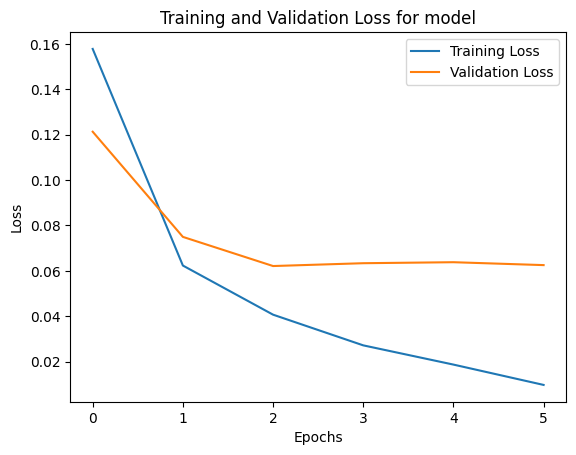

In [64]:
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for model')
plt.legend()
plt.show()

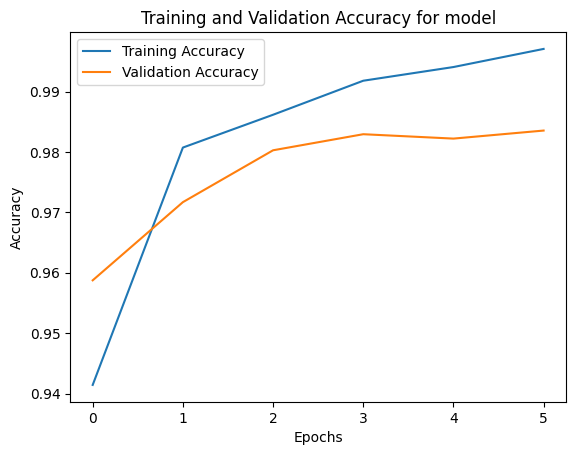

In [65]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for model')
plt.legend()
plt.show()

In [66]:
train['combined_text'] = train['title'] + " " + train['text']

# Tokenization and padding of text
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(train['combined_text'])
train_sequences = tokenizer.texts_to_sequences(train['combined_text'])
word_index = tokenizer.word_index

max_sequence_length = 250
textual_train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)

test['combined_text'] = test['title'] + " " + test['text']
test_sequences = tokenizer.texts_to_sequences(test['combined_text'])
textual_test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

model2 = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=max_sequence_length),  # Applying Embedding layer
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    LSTM(16, return_sequences=False),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','precision','recall'])
callbacks = callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_2.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=0.00001)
]

model2.fit(textual_train_data, train['label'], validation_data=(textual_test_data,test['label']), epochs=20, batch_size=32, callbacks = callbacks)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.9127 - loss: 0.2150 - precision: 0.8904 - recall: 0.9385 - val_accuracy: 0.9758 - val_loss: 0.0759 - val_precision: 0.9568 - val_recall: 0.9947 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9847 - loss: 0.0434 - precision: 0.9824 - recall: 0.9860 - val_accuracy: 0.9862 - val_loss: 0.0537 - val_precision: 0.9869 - val_recall: 0.9844 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9940 - loss: 0.0198 - precision: 0.9938 - recall: 0.9939 - val_accuracy: 0.9861 - val_loss: 0.0487 - val_precision: 0.9854 - val_recall: 0.9857 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9947 - loss: 0.0179 - precision: 0.9941 - recall: 0.9948 - val_accuracy: 0.9817 - val_loss: 0.0589 - val_precision: 0.9898 - val_recall: 0.9721 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - 

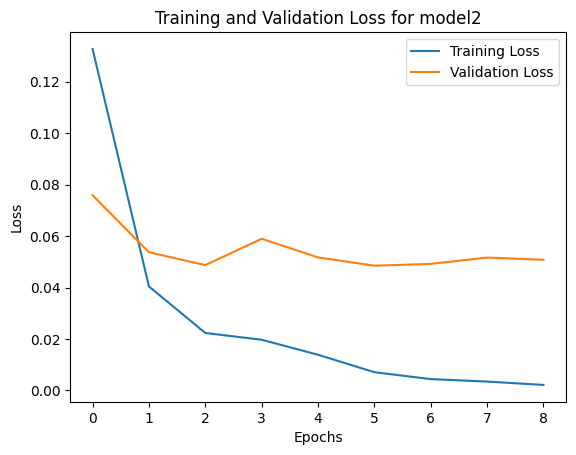

In [68]:
history2 = model2.history.history
plt.plot(history2['loss'], label='Training Loss')
plt.plot(history2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for model2')
plt.legend()
plt.show()

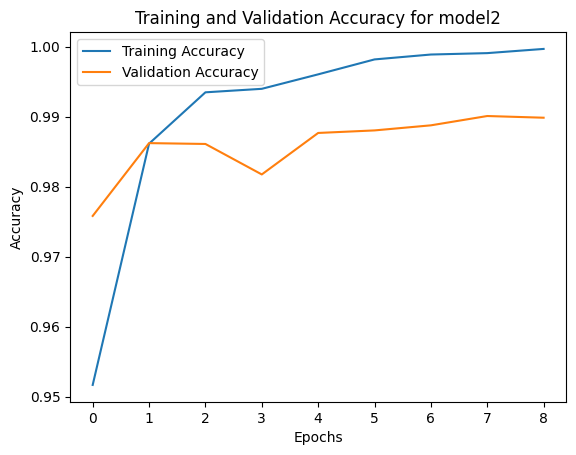

In [69]:
plt.plot(history2['accuracy'], label='Training Accuracy')
plt.plot(history2['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for model2')
plt.legend()
plt.show()

In [70]:
dl_model = load_model('/content/best_model_2.keras')
predictions = dl_model.predict(textual_test_data)

259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [71]:
predictions

array([[5.5479246e-05],
       [9.9991941e-01],
       [3.1721800e-05],
       ...,
       [4.4590786e-01],
       [7.2982589e-06],
       [1.9984192e-05]], dtype=float32)

In [72]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [73]:
print(classification_report(test['label'], binary_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      3983

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267



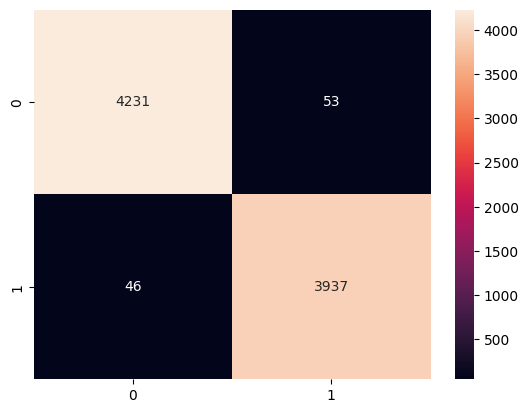

In [79]:
sns.heatmap(confusion_matrix(test['label'], binary_predictions), annot=True, fmt='d')
plt.show()

In [75]:
print("Accuracy: ", accuracy_score(test['label'], binary_predictions))
print("Precision: ", precision_score(test['label'], binary_predictions))
print("Recall: ", recall_score(test['label'], binary_predictions))
print("F1 Score: ", f1_score(test['label'], binary_predictions))
print("ROC AUC: ", roc_auc_score(test['label'], binary_predictions))

Accuracy:  0.9880246764243378
Precision:  0.9867167919799499
Recall:  0.9884509163946774
F1 Score:  0.987583092938668
ROC AUC:  0.9880396505409428


# Result File

In [77]:
output_dl = [[text, int(label)] for text, label in zip(test['text'], binary_predictions.flatten())]
output_file_path = "result.txt"
with open(output_file_path, "w") as file:
    for item in output:
        file.write(f"{item}\n")

In [78]:
output_ml = [[text, int(label)] for text, label in zip(test['text'], y_pred_rfc)]
output_file_path = "results.txt"
with open(output_file_path, "w") as file:
    for item in output:
        file.write(f"{item}\n")